#### Delta Hedging

In [ ]:
# fazer as trajetórias do ativo ao longo do tempo
## gerar um movimento browniano geométrico para isso 
## ao longo de 1 até T

# calcular o PnL ao longo do tempo

# calcular o valor da call ao longo do tempo
## acredito que deve ter que calcular V(t_i, T)

# calcular o delta hedging ao longo do tempo

# juntar essas informações em um gráfico

# fazer isso para os cenários (ITM, OTM e ATM)

# ref: pag 76 cornelis

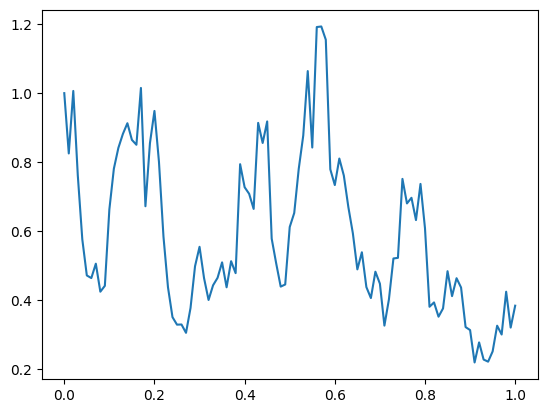

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 2
mu = 0
r = 0.1
S_0 = 1
T = 1
K = 0.95
n=100

def gbm(S0, r, sigma, T, M, I):
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

x = np.linspace(0,T,n+1)
y = [x for x in gbm(S0=S_0, r=mu, sigma=sigma, T=T, M=n, I=1)]

fig, ax = plt.subplots()

ax.plot(x,y)

plt.show()

In [ ]:
# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 10 vezes

# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 2000 vezes

#### funcionamento do GPR

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
S0 = 100  # Preço inicial
mu = r = 0.1  # Taxa de retorno esperada
sigma = 0.2  # Volatilidade
T = 2  # Horizonte de tempo (anos)
N = 3  # Número de passos (aprox. número de dias úteis em um ano)

def gbm(T, N, mu, sigma):
    
    dt = T / N  # Incremento de tempo
    
    # Inicialização dos vetores de tempo e preço
    t = np.linspace(0, T, N)
    S = np.ones(N)
    S[0] = S0

    # Simulação do GBM
    for i in range(0, N):
        Z = np.random.normal()
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return np.array(S)

In [2]:
tamanho_amostra = 2*10**4
numero_ativos = 1
numero_tempo = 10

X = np.array([gbm(2, numero_tempo, mu, sigma) for i in range(tamanho_amostra*numero_ativos)])
# X = X.reshape(numero_ativos*tamanho_amostra, numero_tempo)
X.shape


(20000, 10)

In [15]:
import numpy as np

def f(X, K):
    X_max = max(X)

    call = X_max - K
    return call if call > 0 else 0


n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])


X_train = S
y_train = max_call

X_train.shape

(5, 10)

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# --------------------------------------
# Passo 1: Geração de dados de exemplo
# --------------------------------------
np.random.seed(42)
n_samples = 20
d = 6


X_train = S
y_train = max_call

# Exemplo de função alvo y_j = (|I_j|^{1/2} * g_j) / sqrt(w_j)


# --------------------------------------
# Passo 2: Definição do kernel e GPR
# --------------------------------------
# Limites dos hiperparâmetros
alpha_bounds = (2.8e-5, 83.0)     # bound para ConstantKernel
beta_bounds  = (1e-9, 0.15)       # bound para RBF length_scale
lambda_bounds = (1e-12, 1e-3)     # bound para WhiteKernel noise_level

# Kernel = Constant * RBF + WhiteKernel
kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=alpha_bounds) 
    * RBF(length_scale=1.0, length_scale_bounds=beta_bounds)
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=lambda_bounds)
)

# Instância do regressor gaussiano
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)

# Treinamento do modelo GPR
gpr.fit(X_train, y_train)

# Exibir o kernel ajustado e valor da log-marginal likelihood
print("Kernel ajustado:", gpr.kernel_)
print("Log-marginal likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))


# --------------------------------------
# Passo 3: Teste do modelo e predições
# --------------------------------------
n_test = 200
numero_ativos = 1
numero_tempo = 10

n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])

X_test = S

# Predição via GPR: retorna média e desvio padrão
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Exibir amostras de predição
for i in range(4):
    print(f"X_test[{i}] = {X_test[i]}, y_pred = {y_pred[i]:}, y_std = {y_std[i]:}")


In [35]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

class GaussianExponentiatedKernel(Kernel):
    """k(x,y) = exp(-alpha||x-y||^2 + beta·x^T y), com clipping seguro."""
    def __init__(self, alpha=1.0, beta=0.0,
                 alpha_bounds=(1e-5, 1e5), beta_bounds=(1e-5, 1e5)):
        self.alpha = alpha
        self.beta = beta
        self.alpha_bounds = alpha_bounds
        self.beta_bounds = beta_bounds
        # máximo argumento para np.exp em float64:
        self._max_exp = np.log(np.finfo(float).max)

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        # distâncias quadráticas
        sqdists = np.sum((X[:, None, :] - Y[None, :, :])**2, axis=2)
        # produto interno
        dotprod = X.dot(Y.T)
        # montagem do expoente
        exponent = -self.alpha * sqdists + self.beta * dotprod
        # clipping para evitar overflow
        exponent = np.clip(exponent, -self._max_exp, self._max_exp)
        gram = np.exp(exponent)

        if eval_gradient:
            # gradientes parciais em relação a [alpha, beta]
            grad_alpha = -sqdists * gram
            grad_beta  =  dotprod * gram
            # empilha em (n_x, n_y, 2)
            return gram, np.stack((grad_alpha, grad_beta), axis=2)

        return gram

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return False

    @property
    def theta(self):
        return np.log([self.alpha, self.beta])

    @theta.setter
    def theta(self, theta):
        self.alpha, self.beta = np.exp(theta)

    @property
    def bounds(self):
        return np.log([self.alpha_bounds, self.beta_bounds])
    """Gaussian-Exponentiated kernel: k(x,y) = exp(-alpha||x-y||^2 + beta x^T y)."""
    def __init__(self, alpha=1.0, beta=0.0,
                 alpha_bounds=(1e-5, 1e5), beta_bounds=(1e-5, 1e5)):
        self.alpha = alpha
        self.beta = beta
        self.alpha_bounds = alpha_bounds
        self.beta_bounds = beta_bounds

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        sqdists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        gram = np.exp(-self.alpha * sqdists + self.beta * X.dot(Y.T))
        if eval_gradient:
            # Gradient wrt [alpha, beta]
            grad_alpha = -sqdists * gram
            grad_beta = (X.dot(Y.T)) * gram
            # Stack gradients: shape (n_samples_X, n_samples_Y, n_params)
            return gram, np.stack((grad_alpha, grad_beta), axis=2)
        return gram

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return False

    @property
    def theta(self):
        return np.log([self.alpha, self.beta])

    @theta.setter
    def theta(self, theta):
        self.alpha, self.beta = np.exp(theta)

    @property
    def bounds(self):
        return np.log([self.alpha_bounds, self.beta_bounds])

1º Passo) Gerar X

In [1]:
import numpy as np

n_ativos = 5
tempo_final = 1
n_tempos = 100

X = np.random.normal(size=(n_ativos, n_tempos))
X.shape

(5, 100)

2º Passo) Define a GBM

In [ ]:
def gbm(X, tempo_final, n_tempos, mu, sigma):
    dt = tempo_final / n_tempos  # Incremento de tempo
    
    # Inicialização dos vetores de tempo e preço
    S = np.ones(n_tempos)
    S[0] = 1

    # Simulação do GBM
    for i in range(0, n_tempos):
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * X[i])

    return np.array(S)

mu = 0
sigma = 0.2

S = np.array([gbm(X_i, tempo_final, n_tempos, mu, sigma) for X_i in X])
S.shape

(5, 100)

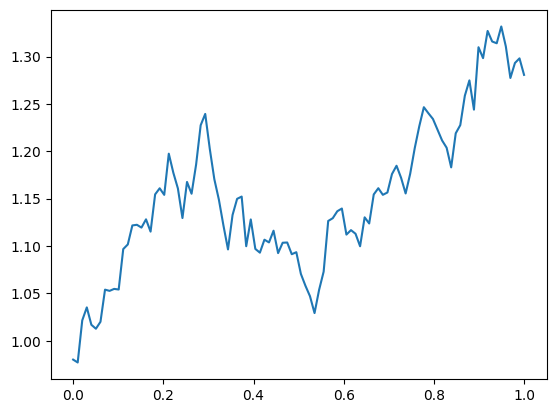

In [5]:
import matplotlib.pyplot as plt

x = np.linspace(0,tempo_final, n_tempos)
y = S[2,:]

fig, ax = plt.subplots()

ax.plot(x,y)

plt.show()

3º Passo) Calculando a $f(X)$

$$
f(X) \;=\; e^{-r \sum_{t=1}^T \Delta_t}\,\bigl(\max_i S_{i,T} - K\bigr)^{+}.
$$

In [6]:
def f(X, tempo_final, n_tempos, mu, sigma, K, r):
    S = gbm(X, tempo_final, n_tempos, mu, sigma)

    S_T = S[-1]
    call = max([S_T - K,0])
    call_desconto = np.exp(-r*tempo_final)*call

    return call_desconto

r = 0
K = 1
n_ativos = 1
tempo_final = 1
n_tempos = 100
mu = 0
sigma = 0.2

X = np.random.normal(size=(n_tempos))
# y = f(X, tempo_final, n_tempos, mu, sigma, K, r)


4º Passo) Replicar o passo 3 'n' vezes

In [42]:
tamanho_amostra = 1000
r = 0
K = 1
n_ativos = 1
tempo_final = 1
n_tempos = 10
mu = 0
sigma = 0.2

X_treino = np.random.normal(size=(tamanho_amostra, n_tempos))
y_treino = np.array([f(X_treino[j,:], tempo_final, n_tempos, mu, sigma, K, r) for j in range(X_treino.shape[0])])

In [24]:
X_treino.shape
y_treino.shape

(1000,)

5º Passo) Usar o GPR para estimar $f_X(X)$

In [43]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel, WhiteKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor


# Passo 2: Definição do kernel e GPR
# --------------------------------------
# Limites dos hiperparâmetros
alpha_bounds = (2.8e-5, 83.0)     # bound para ConstantKernel
beta_bounds  = (1e-9, 0.15)       # bound para RBF length_scale
lambda_bounds = (1e-12, 1e-3)     # bound para WhiteKernel noise_level

kernel = GaussianExponentiatedKernel(alpha=2.53*(10**(-2)), beta=0,
                                     alpha_bounds=(2.8*(10**(-5)),83),
                                     beta_bounds=(10**(-9),0.15))
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=5,
                               normalize_y=True)

# # Instância do regressor gaussiano
# gpr = GaussianProcessRegressor(
#     kernel=kernel,
#     n_restarts_optimizer=10,
#     normalize_y=True
# )

# Treinamento do modelo GPR
gpr.fit(X_treino, y_treino)

# Exibir o kernel ajustado e valor da log-marginal likelihood
print("Kernel ajustado:", gpr.kernel_)
print("Log-marginal likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))

/tmp/ipykernel_184667/2802743031.py:83: RuntimeWarning: divide by zero encountered in log
  return np.log([self.alpha, self.beta])
/home/davi/Desktop/unb/mestrado/precificacao-opcoes/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 0 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/davi/Desktop/unb/mestrado/precificacao-opcoes/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel ajustado: GaussianExponentiatedKernel(-2.56, -8.29)
Log-marginal likelihood: -1.3544759455733129


In [40]:
len(gpr.alpha_)

100

In [53]:
X_test = np.random.normal(size=(tamanho_amostra, n_tempos))
y_test = np.array([f(X_test[j,:], tempo_final, n_tempos, mu, sigma, K, r) for j in range(X_test.shape[0])])

In [55]:
x = X_test[2,:]

array([-1.06337622, -0.37916802,  1.32031398, -0.7400811 , -1.57863992,
        0.89427615, -0.55232246,  0.69886086, -0.57620249, -0.05121805])

In [56]:
gbm(x, tempo_final, n_tempos, mu, sigma)

array([0.998002  , 0.99664449, 0.99592486, 0.99584173, 0.99639495,
       0.99758558, 0.99941589, 1.00188941, 1.0050109 , 1.00878635])

In [57]:
y_test[2]

np.float64(0.0)

In [ ]:
gpr.predict(X_test)

6º Passo) Definir $M_t(X)$, m_s(y_s) e k(x, y) 


$$
M_t(y)
\;=\;
\mathbb{E}_{\mathbb{Q}}\bigl[k(X,y)\mid\mathcal{F}_t\bigr]
\;=\;
\prod_{s=0}^{t} k_s\bigl(X_s,y_s\bigr)
\;\times\;
\prod_{s=t+1}^{T} m_s\bigl(y_s\bigr),
\quad t = 0,\dots,T.
$$```



$$
m_s(y_s)
\;=\;
(1 + 2\alpha)^{-d/2}
\exp\!\Bigl(\frac{\beta^2 + 4\alpha\beta - 2\alpha}{4\alpha + 2}\,\lvert y_s\rvert^2\Bigr).
$$```


$$
k(x, y) \;=\; \exp\!\bigl(-\alpha \lVert x - y \rVert^2 + \beta\,x^\top y\bigr).
$$```


o $y$ que vai em $M_t(y)$ acredito eu que seja o X que vamos predizer.

In [101]:
def m_s(y_s, alpha, beta, d):
    """
    Fator m_s(y_s) = (1+2α)^(-d/2) * exp( ((β²+4αβ-2α)/(4α+2)) * ||y_s||² ).
    
    y_s: array shape (d,)
    alpha, beta: parâmetros
    d: dimensão do vetor y_s
    """
    norm2 = np.dot(y_s, y_s)
    coef = (1 + 2*alpha)**(-d/2)
    exponent = (beta**2 + 4*alpha*beta - 2*alpha) / (4*alpha + 2) * norm2
    return coef * np.exp(exponent)

def kernel_k(x, y, alpha, beta):
    """
    Kernel k(x,y) = exp(-alpha||x-y||^2 + beta * x^T y).
    
    x, y: arrays shape (d,)
    alpha, beta: parâmetros do kernel
    """
    diff = x - y
    return np.exp(-alpha * np.dot(diff, diff) + beta * np.dot(x, y))


def M_t(X_path, y_path, alpha, beta, t):
    """
    Cálculo de M_t(y) = Π_{s=0}^t k(X_s, y_s) * Π_{s=t+1}^T m_s(y_s).
    
    X_path, y_path: arrays shape (T+1, d)
    alpha, beta: parâmetros do kernel
    t: índice de tempo
    """
    T = X_path.shape[1] - 1
    d = 1
    # Produto dos kernels até t
    prod_k = 1.0
    for s in range(t+1):
        prod_k *= kernel_k(X_path[s], y_path[s], alpha, beta)
    # Produto dos fatores m_s para s>t
    prod_m = 1.0
    for s in range(t+1, T+1):
        prod_m *= m_s(y_path[s], alpha, beta, d)
    return prod_k * prod_m

def V_X(X, T, g, n_tempos, alpha, beta, tamanho_amostra):

    t = np.linspace(0, T, n_tempos)
    valores_t = []
    for s in range(t.shape[0]):
        v_x = 0
        
        for j in range(X.shape[0]):
            v_x = v_x + M_t(X_treino, X_treino[j,:], alpha, beta, s)[0]*g[j]

        valores_t.append(v_x/tamanho_amostra)

    return valores_t

g = gpr.alpha_

V_X_t = V_X(X_treino, tempo_final, g, n_tempos, alpha = 2.53*(10**(-2)), beta=0, tamanho_amostra=tamanho_amostra)
V_X_t



[np.float64(0.00017893840666228098),
 np.float64(-0.00011592712177790796),
 np.float64(0.002652598537733471),
 np.float64(0.002768324464859938),
 np.float64(0.002322678675381003),
 np.float64(0.0018384939687224942),
 np.float64(0.001071921522741827),
 np.float64(0.0006024833297357203),
 np.float64(0.00044856828441110084),
 np.float64(0.00029494171008519367)]

In [62]:
np.linspace(0, tempo_final, n_tempos)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])